# Analyze OFF Category Frequencies

Overall Goal: Find food categories that are suitable for search autosuggestion. Use most popular categories as input for manual curation.

Hypothesis: Categories with many products are more popular, i.e. more frequently bought and/or more diverse product palette/manufaturers.

https://world.openfoodfacts.org/categories.json&page=10&page_size=10

In [1]:
from IPython.display import Image
from networkx.drawing.nx_agraph import to_agraph
from openfoodfacts.taxonomy import get_taxonomy, Taxonomy, TaxonomyNode
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import io
import pandas as pd
import networkx as nx
import json
import time

## Download Category Pages

- contains number of products per category

In [2]:
API_URL = "https://world.openfoodfacts.org/categories.json?"

def download_cat_page(page: int):
    params = {"page_size": 1000, "page": page}

    out_file = f"./off_cat_frequencies_page{page}.json"

    # skip download if data has been downloaded before
    if not Path(out_file).exists():
        print(f"LOADING: cat page {page}")
        urlretrieve(API_URL + urlencode(params), out_file)
    else:
        print(f"SKIP: {out_file} already exists")

In [3]:
%%time
for page in range(1,9):
    time.sleep(0.5)
    download_cat_page(page)

SKIP: ./off_cat_frequencies_page1.json already exists
SKIP: ./off_cat_frequencies_page2.json already exists
SKIP: ./off_cat_frequencies_page3.json already exists
SKIP: ./off_cat_frequencies_page4.json already exists
SKIP: ./off_cat_frequencies_page5.json already exists
SKIP: ./off_cat_frequencies_page6.json already exists
SKIP: ./off_cat_frequencies_page7.json already exists
SKIP: ./off_cat_frequencies_page8.json already exists
CPU times: user 137 ms, sys: 4.83 ms, total: 141 ms
Wall time: 4.03 s


## Combine JSON files in DataFrame

In [4]:
def load_cat_as_df(page: int):
    file = f"./off_cat_frequencies_page{page}.json"
    
    # load json file
    with open(file) as f:
        data = json.load(f)

    # create data frame from product information
    return (pd.DataFrame(data['tags'])
              .drop(['url', 'sameAs'], axis=1)
              .set_index('id')
           )

In [5]:
all_dfs = [load_cat_as_df(page) for page in range(1,9)]
cat_df = pd.concat(all_dfs)
# remove duplicates
cat_df = cat_df[~cat_df.index.duplicated()]
# at least 20 products in category
cat_df = cat_df[cat_df.products >= 20]
cat_df

known                             name  \
id                                                                           
en:plant-based-foods-and-beverages      1  Plant-based foods and beverages   
en:plant-based-foods                    1                Plant-based foods   
en:snacks                               1                           Snacks   
en:sweet-snacks                         1                     Sweet snacks   
en:beverages                            1                        Beverages   
...                                   ...                              ...   
en:watercress                           1                       Watercress   
es:alubias-con-verduras                 1          es:Alubias con verduras   
en:poultry-liver                        1                    Poultry liver   
en:legumes-et-derives                   0               legumes-et-derives   
ro:mezeluri-feliate                     0              ro:mezeluri-feliate   

                                    products  
id                                            
en:plant-based-foods-and-beverages    452890  
en:plant-based-foods                  393287  
en:snacks                             275343  
en:sweet-snacks                       202380  
en:beverages                          174087  
...                                      ...  
en:watercress                             20  
es:alubias-con-verduras                   20  
en:poultry-liver                          20  
en:legumes-et-derives                     20  
ro:mezeluri-feliate                       20  

[5519 rows x 3 columns]

## Exploratory Data Analysis

### Categories not in Taxonomy

In [6]:
cat_df.known.value_counts()

known
1    4514
0    1005
Name: count, dtype: int64

In [7]:
cat_df[lambda x: x.known == 0]

known                         name  products
id                                                                          
en:groceries                        0                    groceries     72006
en:salted-snacks                    0                salted-snacks      7638
en:salads                           0                       salads      4537
en:baking-decorations               0           baking-decorations      2742
en:bars-covered-with-chocolate      0  bars-covered-with-chocolate      2335
...                               ...                          ...       ...
fr:moutardes-mi-fortes              0       fr:moutardes-mi-fortes        20
pt:refrigerante                     0              pt:refrigerante        20
fr:confitures-de-cedrats            0     fr:confitures-de-cedrats        20
en:legumes-et-derives               0           legumes-et-derives        20
ro:mezeluri-feliate                 0          ro:mezeluri-feliate        20

[1005 rows x 3 columns]

### Countries

In [8]:
cat_df.index.str[:2].value_counts()

id
en    4526
fr     691
es     100
it      82
de      77
pl       7
ru       7
pt       7
ro       6
nl       4
ca       3
bg       2
hr       1
af       1
hu       1
gr       1
th       1
cs       1
xx       1
Name: count, dtype: int64

## Augment with Taxonomy Data

### Load Taxonomy

In [9]:
categories: Taxonomy = get_taxonomy("category")
print(f"categories: {len(categories):,}")

categories: 13,404


### Add Localized German Category Name

In [10]:
def add_localized_name(lang):
    cat_df[f'name_{lang}'] = cat_df.index.map(lambda x: categories[x].names.get(lang) if categories[x] else None)    

#lang = 'de'
#cat_df[f'name_{lang}'] = cat_df.index.map(lambda x: categories[x].names.get(lang) if categories[x] else None)
add_localized_name('en')
add_localized_name('de')
cat_df

known                             name  \
id                                                                           
en:plant-based-foods-and-beverages      1  Plant-based foods and beverages   
en:plant-based-foods                    1                Plant-based foods   
en:snacks                               1                           Snacks   
en:sweet-snacks                         1                     Sweet snacks   
en:beverages                            1                        Beverages   
...                                   ...                              ...   
en:watercress                           1                       Watercress   
es:alubias-con-verduras                 1          es:Alubias con verduras   
en:poultry-liver                        1                    Poultry liver   
en:legumes-et-derives                   0               legumes-et-derives   
ro:mezeluri-feliate                     0              ro:mezeluri-feliate   

                                    products                          name_en  \
id                                                                              
en:plant-based-foods-and-beverages    452890  Plant-based foods and beverages   
en:plant-based-foods                  393287                Plant-based foods   
en:snacks                             275343                           Snacks   
en:sweet-snacks                       202380                     Sweet snacks   
en:beverages                          174087                        Beverages   
...                                      ...                              ...   
en:watercress                             20                       Watercress   
es:alubias-con-verduras                   20                             None   
en:poultry-liver                          20                    Poultry liver   
en:legumes-et-derives                     20                             None   
ro:mezeluri-feliate                       20                             None   

                                                                  name_de  
id                                                                         
en:plant-based-foods-and-beverages  Pflanzliche Lebensmittel und Getränke  
en:plant-based-foods                             Pflanzliche Lebensmittel  
en:snacks                                                          Imbiss  
en:sweet-snacks                                               Süßer Snack  
en:beverages                                                     Getränke  
...                                                                   ...  
en:watercress                                               Brunnenkresse  
es:alubias-con-verduras                                              None  
en:poultry-liver                                            Geflügelleber  
en:legumes-et-derives                                                None  
ro:mezeluri-feliate                                                  None  

[5519 rows x 5 columns]

### Add parents and parent/child counts

In [11]:
cat_df['parents'] = cat_df.index.map(lambda x: '|'.join([p.id for p in categories[x].parents]) if categories[x] else None)
cat_df['num_parents'] = cat_df.index.map(lambda x: len(categories[x].parents) if categories[x] else -1)
cat_df['num_children'] = cat_df.index.map(lambda x: len(categories[x].children) if categories[x] else -1)
cat_df

known                             name  \
id                                                                           
en:plant-based-foods-and-beverages      1  Plant-based foods and beverages   
en:plant-based-foods                    1                Plant-based foods   
en:snacks                               1                           Snacks   
en:sweet-snacks                         1                     Sweet snacks   
en:beverages                            1                        Beverages   
...                                   ...                              ...   
en:watercress                           1                       Watercress   
es:alubias-con-verduras                 1          es:Alubias con verduras   
en:poultry-liver                        1                    Poultry liver   
en:legumes-et-derives                   0               legumes-et-derives   
ro:mezeluri-feliate                     0              ro:mezeluri-feliate   

                                    products                          name_en  \
id                                                                              
en:plant-based-foods-and-beverages    452890  Plant-based foods and beverages   
en:plant-based-foods                  393287                Plant-based foods   
en:snacks                             275343                           Snacks   
en:sweet-snacks                       202380                     Sweet snacks   
en:beverages                          174087                        Beverages   
...                                      ...                              ...   
en:watercress                             20                       Watercress   
es:alubias-con-verduras                   20                             None   
en:poultry-liver                          20                    Poultry liver   
en:legumes-et-derives                     20                             None   
ro:mezeluri-feliate                       20                             None   

                                                                  name_de  \
id                                                                          
en:plant-based-foods-and-beverages  Pflanzliche Lebensmittel und Getränke   
en:plant-based-foods                             Pflanzliche Lebensmittel   
en:snacks                                                          Imbiss   
en:sweet-snacks                                               Süßer Snack   
en:beverages                                                     Getränke   
...                                                                   ...   
en:watercress                                               Brunnenkresse   
es:alubias-con-verduras                                              None   
en:poultry-liver                                            Geflügelleber   
en:legumes-et-derives                                                None   
ro:mezeluri-feliate                                                  None   

                                                                    parents  \
id                                                                            
en:plant-based-foods-and-beverages                                            
en:plant-based-foods                     en:plant-based-foods-and-beverages   
en:snacks                                                                     
en:sweet-snacks                                                   en:snacks   
en:beverages                        en:beverages-and-beverages-preparations   
...                                                                     ...   
en:watercress                                            en:leaf-vegetables   
es:alubias-con-verduras                              en:prepared-vegetables   
en:poultry-liver                                               en:poultries   
en:legumes-et-derives                                                  None   
ro:mezeluri-felia

### Parent Analytics

- number of parents

In [12]:
cat_df.num_parents.value_counts()

num_parents
 1    3416
-1    1017
 2     956
 3      72
 0      54
 4       4
Name: count, dtype: int64

- most popular parent

In [13]:
cat_df.parents.value_counts()

parents
en:sauces                                     58
                                              54
en:cheeses                                    51
en:meals                                      49
en:pastas                                     43
                                              ..
en:block-of-foie-gras                          1
en:chipolatas                                  1
en:cereals-with-fruits|en:extruded-cereals     1
en:legume-flours                               1
en:cervelat                                    1
Name: count, Length: 1892, dtype: int64

- number of children

In [14]:
cat_df.num_children.value_counts()

num_children
 0     2527
-1     1017
 1      532
 2      399
 3      240
       ... 
 33       1
 96       1
 94       1
 60       1
 38       1
Name: count, Length: 64, dtype: int64

### Root Categories

Categories without parents. They are very generic.

In [15]:
cat_df[lambda x: x.num_parents == 0]

known  \
id                                               
en:plant-based-foods-and-beverages           1   
en:snacks                                    1   
en:dairies                                   1   
en:meats-and-their-products                  1   
en:fermented-foods                           1   
en:condiments                                1   
en:desserts                                  1   
en:meals                                     1   
en:spreads                                   1   
en:frozen-foods                              1   
en:breakfasts                                1   
en:cocoa-and-its-products                    1   
en:canned-foods                              1   
en:seafood                                   1   
en:fats                                      1   
en:sweeteners                                1   
en:farming-products                          1   
en:dried-products                            1   
en:bee-products                              1   
en:dietary-supplements                       1   
en:chips-and-fries                           1   
en:beverages-and-beverages-preparations      1   
en:meat-alternatives                         1   
en:cooking-helpers                           1   
en:syrups                                    1   
en:fresh-foods                               1   
en:festive-foods                             1   
en:sandwiches                                1   
en:breaded-products                          1   
en:non-food-products                         1   
en:fish-and-meat-and-eggs                    1   
en:baby-foods                                1   
en:food-additives                            1   
en:pies                                      1   
en:specific-products                         1   
en:terrines                                  1   
en:sweet-pies                                1   
en:capsules                                  1   
en:broths                                    1   
en:crepes-and-galettes                       1   
en:refrigerated-foods                        1   
en:mountain-products                         1   
en:artisan-products                          1   
en:purees                                    1   
en:food-decorations                          1   
en:bread-coverings                           1   
en:skewers                                   1   
en:stuffing                                  1   
en:variety-packs                             1   
en:fried-foods                               1   
en:meal-kits                                 1   
en:freeze-dried-foods                        1   
en:brick-sheets                              1   
fr:de-matieres-grasses                       0   

                                                                         name  \
id                                                                              
en:plant-based-foods-and-beverages            Plant-based foods and beverages   
en:snacks                                                              Snacks   
en:dairies                                                            Dairies   
en:meats-and-their-products                          Meats and their products   
en:fermented-foods                                            Fermented foods   
en:condiments                                                      Condiments   
en:desserts                                                          Desserts   
en:meals                                                                Meals   
en:spreads                                                            Spreads   
en:frozen-foods                                                  Frozen foods   
en:breakfasts                                                      Breakfasts   
en:cocoa-and-its-products                              Cocoa and its products   
en:canned-foods                                                  Canned foods   
en:seafood               

### No Children

In [16]:
cat_df[lambda x: x.num_children == 0]

known                         name  products  \
id                                                                             
en:sweetened-beverages              1          Sweetened beverages     11144   
en:extra-virgin-olive-oils          1      Extra-virgin olive oils     10141   
en:virgin-olive-oils                1            Virgin olive oils      9357   
en:protein-powders                  1              Protein powders      5209   
en:open-beauty-facts                1            Open Beauty Facts      4725   
...                               ...                          ...       ...   
en:steviol-glycosides               1           Steviol glycosides        20   
en:saveloy-from-obernai-alsace      1  Saveloy from Obernai Alsace        20   
fr:muscadet-sevre-et-maine          1   fr:Muscadet-Sèvre et Maine        20   
es:alubias-con-verduras             1      es:Alubias con verduras        20   
en:poultry-liver                    1                Poultry liver        20   

                                                    name_en  \
id                                                            
en:sweetened-beverages                  Sweetened beverages   
en:extra-virgin-olive-oils          Extra-virgin olive oils   
en:virgin-olive-oils                      Virgin olive oils   
en:protein-powders                          Protein powders   
en:open-beauty-facts                      Open Beauty Facts   
...                                                     ...   
en:steviol-glycosides                    Steviol glycosides   
en:saveloy-from-obernai-alsace  Saveloy from Obernai Alsace   
fr:muscadet-sevre-et-maine                             None   
es:alubias-con-verduras                                None   
en:poultry-liver                              Poultry liver   

                                               name_de  \
id                                                       
en:sweetened-beverages             Gezuckerte Getränke   
en:extra-virgin-olive-oils      Native Olivenöle Extra   
en:virgin-olive-oils                  Native Olivenöle   
en:protein-powders                       Proteinpulver   
en:open-beauty-facts                              None   
...                                                ...   
en:steviol-glycosides                             None   
en:saveloy-from-obernai-alsace                    None   
fr:muscadet-sevre-et-maine                        None   
es:alubias-con-verduras                           None   
en:poultry-liver                         Geflügelleber   

                                                                          parents  \
id                                                                                  
en:sweetened-beverages                                               en:beverages   
en:extra-virgin-olive-oils                                          en:olive-oils   
en:virgin-olive-oils                                                en:olive-oils   
en:protein-powders                                    en:bodybuilding-supplements   
en:open-beauty-facts                                         en:non-food-products   
...                                                                           ...   
en:steviol-glycosides           en:natural-sugar-substitutes|en:stevia-and-the...   
en:saveloy-from-obernai-alsace                                        en:cervelat   
fr:muscadet-sevre-et-maine                                   en:wines-from-france   
es:alubias-con-verduras                                    en:prepared-vegetables   
en:poultry-liver                                                     en:poultries   

                                num_parents  num_children  
id                                                         
en:sweetened-beverages                    1             0  
en:extra-virgin-olive-oils                1             0  
en:virgin-olive-oils                      1             0  
en:protein

### Many Children

In [17]:
cat_df[lambda x: x.num_children >20]

known                      name  products  \
id                                                                       
en:plant-based-foods             1         Plant-based foods    393287   
en:beverages                     1                 Beverages    174087   
en:meats-and-their-products      1  Meats and their products    126902   
en:meats                         1                     Meats     98649   
en:desserts                      1                  Desserts     87471   
...                            ...                       ...       ...   
en:olive-oils-from-greece        1    Olive oils from Greece        90   
en:wines-from-germany            1        Wines from Germany        54   
en:chablis                       1                   Chablis        40   
en:cooked-beef-meat              1          Cooked beef meat        29   
en:wines-from-hungary            1        Wines from Hungary        21   

                                              name_en  \
id                                                      
en:plant-based-foods                Plant-based foods   
en:beverages                                Beverages   
en:meats-and-their-products  Meats and their products   
en:meats                                        Meats   
en:desserts                                  Desserts   
...                                               ...   
en:olive-oils-from-greece      Olive oils from Greece   
en:wines-from-germany              Wines from Germany   
en:chablis                                    Chablis   
en:cooked-beef-meat                  Cooked beef meat   
en:wines-from-hungary              Wines from Hungary   

                                                         name_de  \
id                                                                 
en:plant-based-foods                    Pflanzliche Lebensmittel   
en:beverages                                            Getränke   
en:meats-and-their-products  Auf Fleisch basierende Lebensmittel   
en:meats                                                 Fleisch   
en:desserts                                             Desserts   
...                                                          ...   
en:olive-oils-from-greece             Olivenöle aus Griechenland   
en:wines-from-germany                      Weine aus Deutschland   
en:chablis                                                  None   
en:cooked-beef-meat                                         None   
en:wines-from-hungary                           Weine aus Ungarn   

                                                             parents  \
id                                                                     
en:plant-based-foods              en:plant-based-foods-and-beverages   
en:beverages                 en:beverages-and-beverages-preparations   
en:meats-and-their-products                                            
en:meats                                 en:meats-and-their-products   
en:desserts                                                            
...                                                              ...   
en:olive-oils-from-greece       en:greek-oils-and-fats|en:olive-oils   
en:wines-from-germany                                       en:wines   
en:chablis                          en:burgundy-wines|en:white-wines   
en:cooked-beef-meat                       en:beef|en:cooked-red-meat   
en:wines-from-hungary                                       en:wines   

                             num_parents  num_children  
id                                                      
en:plant-based-foods                   1            52  
en:beverages                           1            22  
en:meats-and-their-products            0            35  
en:meats                               1            31  
en:desserts                            0            48  
...                                  ...           ...  
en:olive-oils-from-greece              2      

### Categories with Stopwords

Stopwords: with

In [18]:
cat_df[cat_df.index.str.contains("with")].index

Index(['en:meals-with-meat', 'en:fermented-dairy-desserts-with-fruits',
       'en:meals-with-fish', 'en:meals-with-chicken',
       'en:soft-cheeses-with-bloomy-rind', 'en:products-without-gluten',
       'en:bars-covered-with-chocolate', 'en:cereals-with-fruits',
       'en:mueslis-with-fruits', 'en:chocolates-with-hazelnuts',
       ...
       'en:lemonade-with-sugar-and-artificial-sweeteners',
       'en:pasta-salad-with-tuna', 'en:puffed-corn-cakes-with-milk-chocolate',
       'en:yogurt-fruit-flavoured-with-sugar-no-0-fat',
       'en:soft-ripened-cheese-with-bloomy-rind',
       'en:soft-cake-filled-with-chocolate',
       'en:canned-raviolis-filled-with-meat-in-tomato-sauce',
       'en:breakfast-biscuit-with-chocolate',
       'en:bottled-water-flavoured-without-sugar-and-with-artificial-sweeteners',
       'en:pizza-with-raclette-cheese-and-lardoons'],
      dtype='object', name='id', length=337)

## Graph Visualization

In [19]:
def add_subgraph(G, cat: TaxonomyNode, max_depth: int = -1):
    '''Add a taxonomy node and all it's children to a graph.'''
    if max_depth == 0:
        return
    children = [n for n in cat.children if n.id in cat_df.index]
    count = cat_df.loc[cat.id].products
    for child in children:
        cnt = cat_df.loc[child.id].products
        G.add_edge(f'{cat.id} ({count:,})', f'{child.id} ({cnt:,})')
        add_subgraph(G, child, max_depth-1)

def show_children(id):
    ids = [n.id for n in categories[id].children if n.id in cat_df.index]
    return cat_df.loc[ids].sort_values('products', ascending=False)

def plot_graph(cat: TaxonomyNode, max_depth: int = -1):
    G = nx.DiGraph()
    add_subgraph(G, cat, max_depth)
    
    # Convert NetworkX graph to a PyGraphviz AGraph
    A = to_agraph(G)
    
    # Set global graph attributes
    A.graph_attr['rankdir'] = 'LR'  # Left to right
    A.graph_attr['nodesep'] = '0.1'
    A.graph_attr['ranksep'] = '0.5'
    
    # Set node attributes
    for node in A.nodes():
        n = A.get_node(node)
        n.attr['shape'] = 'box'
        n.attr['height'] = '0'  # Remove top/bottom padding
        n.attr['fontsize'] = '10'
    
    # Draw the graph and store the result in an in-memory buffer
    A.layout(prog='dot')
    
    # Create an in-memory buffer
    buffer = io.BytesIO()
    A.draw(buffer, format='png')
    buffer.seek(0)
    
    return Image(data=buffer.read(), format='png')

# pydot is deprecated
import pydot
from networkx.drawing.nx_pydot import to_pydot

def plt_graph(G, png_file):
    # Convert NetworkX graph to a PyDot graph object
    P = to_pydot(G)
    
    P.set('rankdir', 'LR') # left to right
    P.set('nodesep', '0.1')
    P.set('ranksep', '0.5')
    
    for node in P.get_nodes():
        node.set_shape('box')
        node.set_height(0) # remove top/bottom padding
        node.set_fontsize(10)
    
    # visualize the graph
    P.write_png(png_file)

### Investigate Teas (and steaks)

In [20]:
cat_df[cat_df.index.str.contains("tea")].head(10)

known                 name  products  \
id                                                             
en:teas                     1                 Teas     13569   
en:tea-based-beverages      1  Tea-based beverages      6878   
en:herbal-teas              1          Herbal teas      6206   
en:iced-teas                1            Iced teas      4248   
en:green-teas               1           Green teas      2501   
en:tea-bags                 1             Tea bags      2361   
en:steaks                   1               Steaks      1619   
en:beef-steaks              1          Beef steaks      1393   
en:ground-steaks            1        Ground steaks      1226   
en:ground-beef-steaks       1   Ground beef steaks      1171   

                                    name_en                name_de  \
id                                                                   
en:teas                                Teas                   Tees   
en:tea-based-beverages  Tea-based beverages            Teegetränke   
en:herbal-teas                  Herbal teas            Kräutertees   
en:iced-teas                      Iced teas                Eistees   
en:green-teas                    Green teas             Grüne Tees   
en:tea-bags                        Tea bags              Teebeutel   
en:steaks                            Steaks                 Steaks   
en:beef-steaks                  Beef steaks           Rindersteaks   
en:ground-steaks              Ground steaks      Hackfleischsteaks   
en:ground-beef-steaks    Ground beef steaks  Hackfleischrindsteaks   

                                                          parents  \
id                                                                  
en:teas                 en:hot-beverages|en:plant-based-beverages   
en:tea-based-beverages                               en:beverages   
en:herbal-teas                           en:beverage-preparations   
en:iced-teas                               en:tea-based-beverages   
en:green-teas                                             en:teas   
en:tea-bags                                         en:tea-leaves   
en:steaks                                                en:meats   
en:beef-steaks                                  en:beef|en:steaks   
en:ground-steaks                                        en:steaks   
en:ground-beef-steaks             en:beef-steaks|en:ground-steaks   

                        num_parents  num_children  
id                                                 
en:teas                           2            11  
en:tea-based-beverages            1             4  
en:herbal-teas                    1            47  
en:iced-teas                      1             6  
en:green-teas                     1             6  
en:tea-bags                       1             0  
en:steaks                         1             5  
en:beef-steaks                    2             2  
en:ground-steaks                  1             4  
en:ground-beef-steaks             2             7

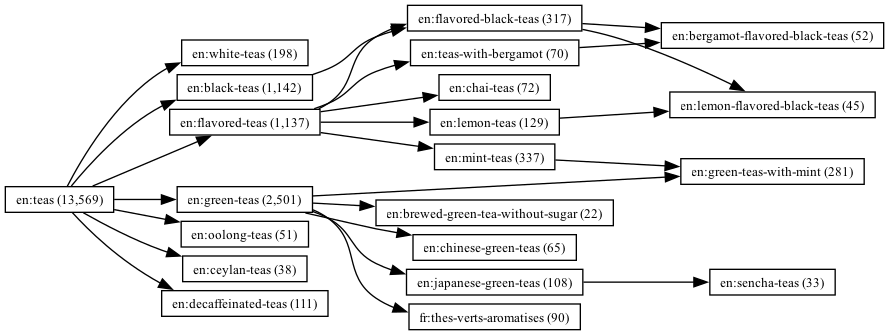

In [21]:
plot_graph(categories['en:teas'])

## Analyze Root Categories

In [22]:
show_children('en:plant-based-foods-and-beverages')

known  \
id                                              
en:plant-based-foods                        1   
en:plant-based-beverages                    1   
en:dairy-substitutes                        1   
en:vegetable-based-foods-and-beverages      1   

                                                                       name  \
id                                                                            
en:plant-based-foods                                      Plant-based foods   
en:plant-based-beverages                              Plant-based beverages   
en:dairy-substitutes                                      Dairy substitutes   
en:vegetable-based-foods-and-beverages  Vegetable-based foods and beverages   

                                        products  \
id                                                 
en:plant-based-foods                      393287   
en:plant-based-beverages                   61329   
en:dairy-substitutes                       13856   
en:vegetable-based-foods-and-beverages      1419   

                                                                    name_en  \
id                                                                            
en:plant-based-foods                                      Plant-based foods   
en:plant-based-beverages                              Plant-based beverages   
en:dairy-substitutes                                      Dairy substitutes   
en:vegetable-based-foods-and-beverages  Vegetable-based foods and beverages   

                                                                          name_de  \
id                                                                                  
en:plant-based-foods                                     Pflanzliche Lebensmittel   
en:plant-based-beverages                                     Pflanzliche Getränke   
en:dairy-substitutes                                                         None   
en:vegetable-based-foods-and-beverages  Gemüse basierte Lebensmittel und Getränke   

                                                                                parents  \
id                                                                                        
en:plant-based-foods                                 en:plant-based-foods-and-beverages   
en:plant-based-beverages                en:beverages|en:plant-based-foods-and-beverages   
en:dairy-substitutes                                 en:plant-based-foods-and-beverages   
en:vegetable-based-foods-and-beverages               en:plant-based-foods-and-beverages   

                                        num_parents  num_children  
id                                                                 
en:plant-based-foods                              1            52  
en:plant-based-beverages                          2            14  
en:dairy-substitutes                              1             8  
en:vegetable-based-foods-and-beverages            1             1

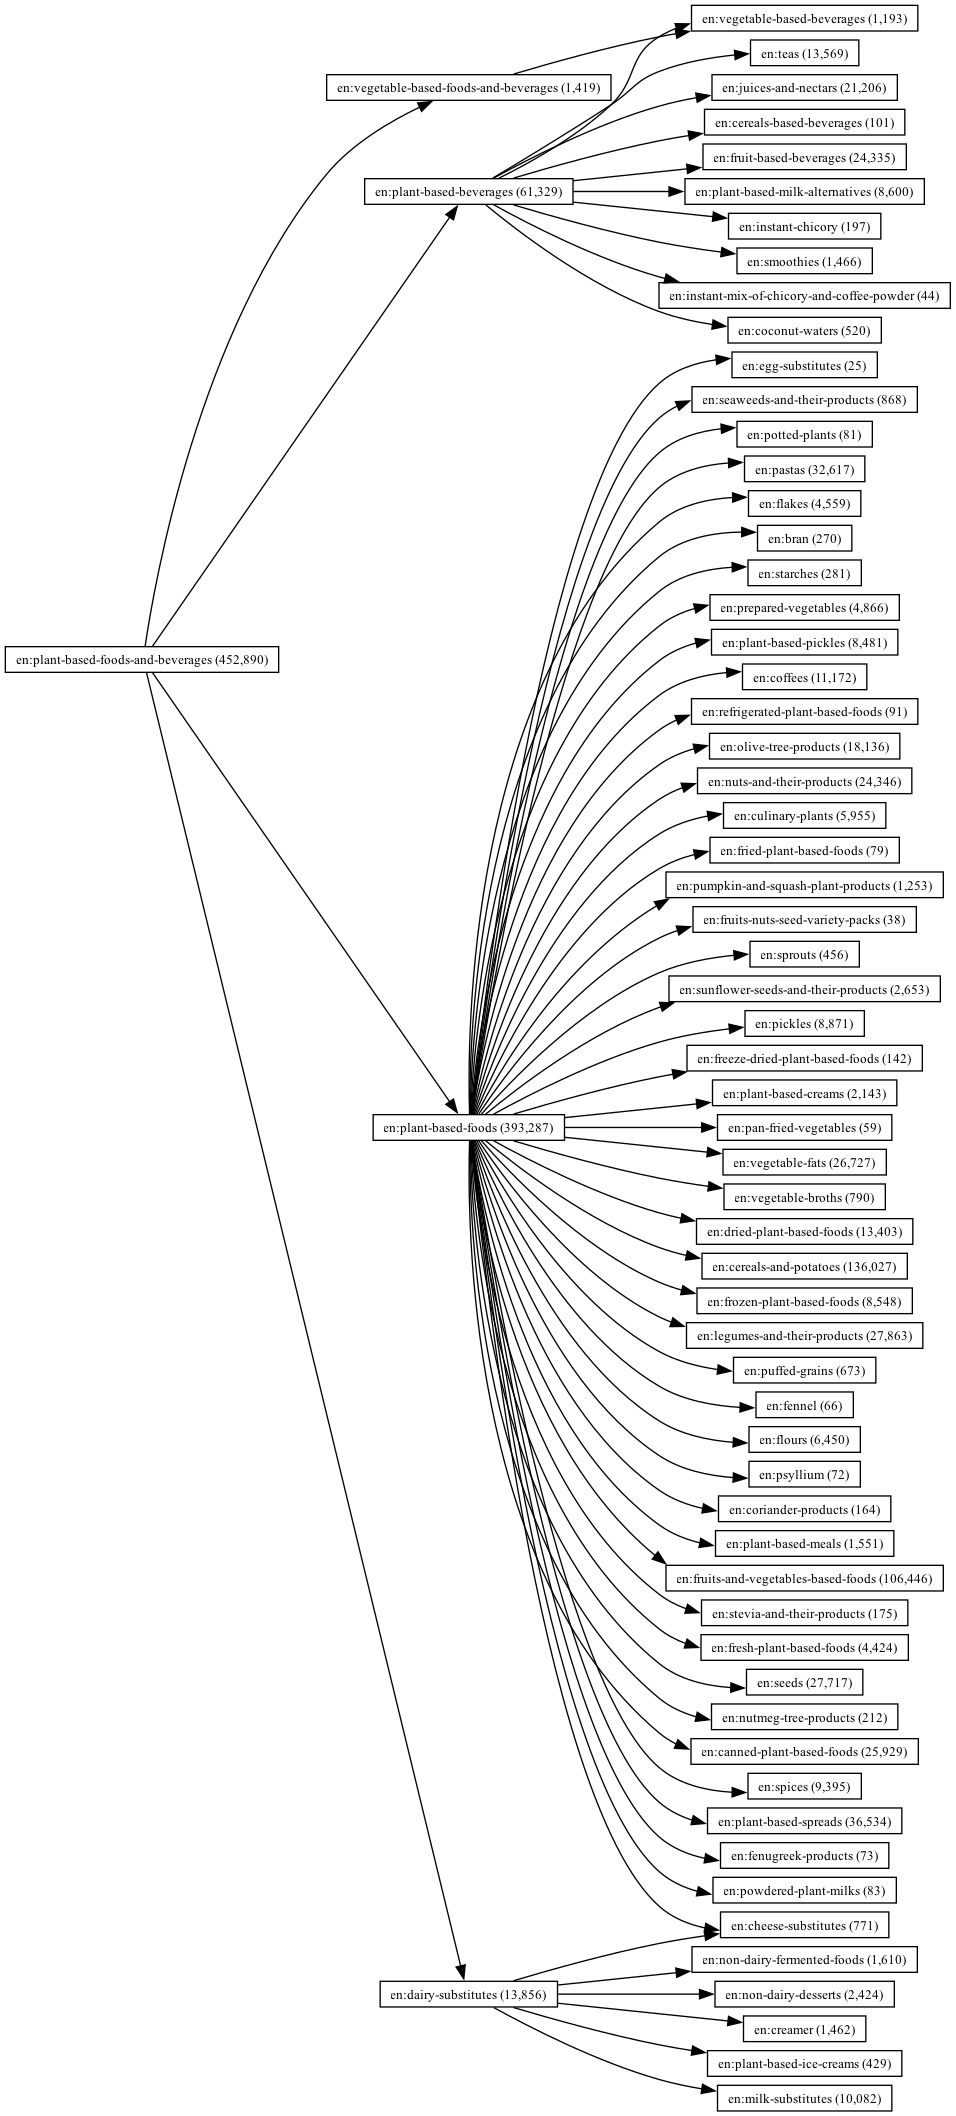

In [23]:
plot_graph(categories['en:plant-based-foods-and-beverages'], max_depth=2)

### Plant-based Beverages

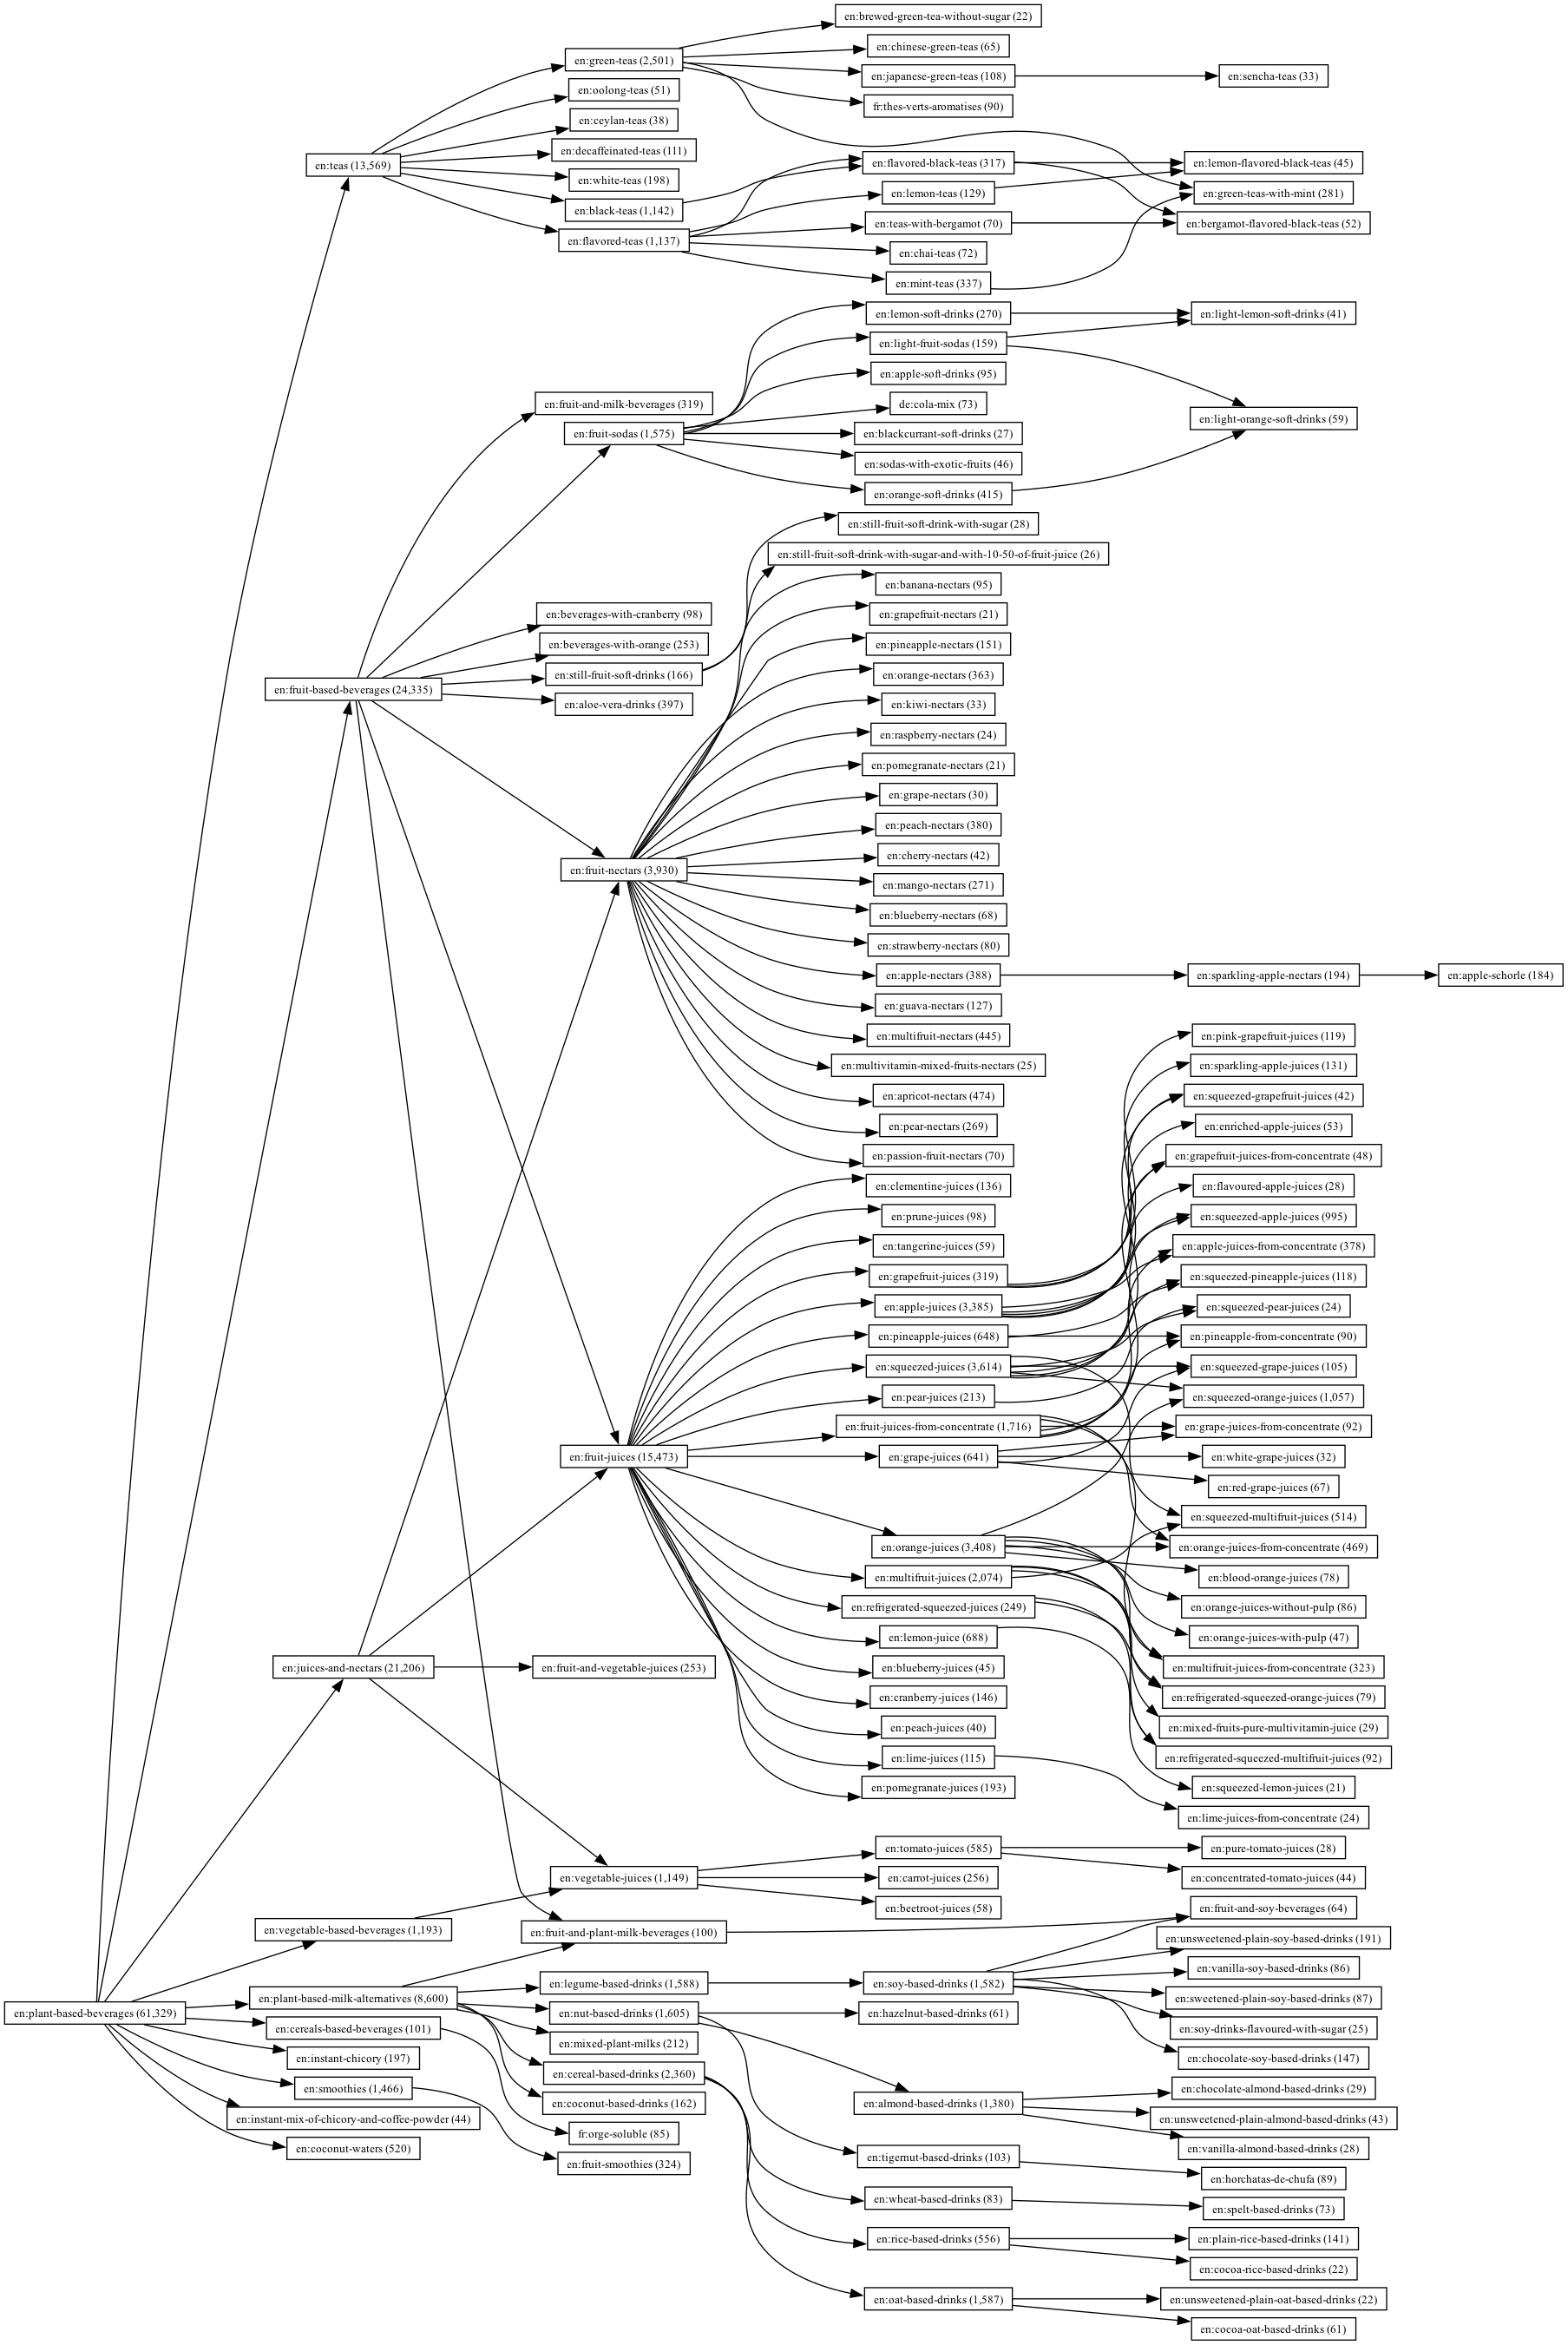

In [24]:
plot_graph(categories['en:plant-based-beverages'])

In [25]:
show_children('en:plant-based-beverages')

known  \
id                                                   
en:fruit-based-beverages                         1   
en:juices-and-nectars                            1   
en:teas                                          1   
en:plant-based-milk-alternatives                 1   
en:smoothies                                     1   
en:vegetable-based-beverages                     1   
en:coconut-waters                                1   
en:instant-chicory                               1   
en:cereals-based-beverages                       1   
en:instant-mix-of-chicory-and-coffee-powder      1   

                                                                                 name  \
id                                                                                      
en:fruit-based-beverages                                        Fruit-based beverages   
en:juices-and-nectars                                              Juices and nectars   
en:teas                                                                          Teas   
en:plant-based-milk-alternatives                        Plant-based milk alternatives   
en:smoothies                                                                Smoothies   
en:vegetable-based-beverages                                Vegetable-based beverages   
en:coconut-waters                                                      Coconut waters   
en:instant-chicory                                                    Instant chicory   
en:cereals-based-beverages                                    Cereals-based beverages   
en:instant-mix-of-chicory-and-coffee-powder  Instant mix of chicory and coffee powder   

                                             products  \
id                                                      
en:fruit-based-beverages                        24335   
en:juices-and-nectars                           21206   
en:teas                                         13569   
en:plant-based-milk-alternatives                 8600   
en:smoothies                                     1466   
en:vegetable-based-beverages                     1193   
en:coconut-waters                                 520   
en:instant-chicory                                197   
en:cereals-based-beverages                        101   
en:instant-mix-of-chicory-and-coffee-powder        44   

                                                                              name_en  \
id                                                                                      
en:fruit-based-beverages                                        Fruit-based beverages   
en:juices-and-nectars                                              Juices and nectars   
en:teas                                                                          Teas   
en:plant-based-milk-alternatives                        Plant-based milk alternatives   
en:smoothies                                                                Smoothies   
en:vegetable-based-beverages                                Vegetable-based beverages   
en:coconut-waters                                                      Coconut waters   
en:instant-chicory                                                    Instant chicory   
en:cereals-based-beverages                                    Cereals-based beverages   
en:instant-mix-of-chicory-and-coffee-powder  Instant mix of chicory and coffee powder   

                                                              name_de  \
id                                                                      
en:fruit-based-beverages                               Fruchtgetränke   
en:juices-and-nectars                               Säfte und Nektare   
en:teas                                                          Tees   
en:plant-based-milk-alternatives                        Pflanzenmilch   
en:smoothies                                                Smoothies   
en:vegetable-based-beverages                 Gemüse basierte G

### Juices and Nectars

- ignore
  - refrigerated
  - from-concentrate (not healthy)
  - en:fruit-juice-mixed-apple-base-standard
- keep squeezed (Direktsaft)

In [26]:
show_children('en:fruit-juices')

known                           name  \
id                                                                       
en:squeezed-juices                    1                Squeezed juices   
en:orange-juices                      1                  Orange juices   
en:apple-juices                       1                   Apple juices   
en:multifruit-juices                  1              Multifruit juices   
en:fruit-juices-from-concentrate      1  Fruit juices from concentrate   
en:lemon-juice                        1                    Lemon juice   
en:pineapple-juices                   1               Pineapple juices   
en:grape-juices                       1                   Grape juices   
en:grapefruit-juices                  1              Grapefruit juices   
en:refrigerated-squeezed-juices       1   Refrigerated squeezed juices   
en:pear-juices                        1                    Pear juices   
en:pomegranate-juices                 1             Pomegranate juices   
en:cranberry-juices                   1               Cranberry juices   
en:clementine-juices                  1              Clementine juices   
en:lime-juices                        1                    Lime juices   
en:prune-juices                       1                   Prune juices   
en:tangerine-juices                   1               Tangerine juices   
en:blueberry-juices                   1               Blueberry juices   
en:peach-juices                       1                   Peach juices   

                                  products                        name_en  \
id                                                                          
en:squeezed-juices                    3614                Squeezed juices   
en:orange-juices                      3408                  Orange juices   
en:apple-juices                       3385                   Apple juices   
en:multifruit-juices                  2074              Multifruit juices   
en:fruit-juices-from-concentrate      1716  Fruit juices from concentrate   
en:lemon-juice                         688                    Lemon juice   
en:pineapple-juices                    648               Pineapple juices   
en:grape-juices                        641                   Grape juices   
en:grapefruit-juices                   319              Grapefruit juices   
en:refrigerated-squeezed-juices        249   Refrigerated squeezed juices   
en:pear-juices                         213                    Pear juices   
en:pomegranate-juices                  193             Pomegranate juices   
en:cranberry-juices                    146               Cranberry juices   
en:clementine-juices                   136              Clementine juices   
en:lime-juices                         115                    Lime juices   
en:prune-juices                         98                   Prune juices   
en:tangerine-juices                     59               Tangerine juices   
en:blueberry-juices                     45               Blueberry juices   
en:peach-juices                         40                   Peach juices   

                                                     name_de  \
id                                                             
en:squeezed-juices                               Direktsäfte   
en:orange-juices                                Orangensäfte   
en:apple-juices                                    Apfelsaft   
en:multifruit-juices                        Multifruchtsäfte   
en:fruit-juices-from-concentrate  Fruchtsäfte aus Konzentrat   
en:lemon-juice                                 Zitronensäfte   
en:pineapple-juices                              Ananassäfte   
en:grape-juices                                 Traubensäfte   
en:grapefruit-juices                         Grapefruitsäfte   
en:refrigerated-squeezed-juices         Gekühlte Direktsäfte   
en:pear-juices                                   Birnensäfte   
en:pomegranate-juices        

In [27]:
show_children('en:squeezed-juices')

known                        name  products  \
id                                                                           
en:squeezed-orange-juices          1      Squeezed orange juices      1057   
en:squeezed-apple-juices           1       Squeezed apple juices       995   
en:squeezed-multifruit-juices      1  Squeezed multifruit juices       514   
en:squeezed-pineapple-juices       1   Squeezed pineapple juices       118   
en:squeezed-grape-juices           1       Squeezed grape juices       105   
en:squeezed-grapefruit-juices      1  Squeezed grapefruit juices        42   
en:squeezed-pear-juices            1        Squeezed pear juices        24   

                                                  name_en  \
id                                                          
en:squeezed-orange-juices          Squeezed orange juices   
en:squeezed-apple-juices            Squeezed apple juices   
en:squeezed-multifruit-juices  Squeezed multifruit juices   
en:squeezed-pineapple-juices    Squeezed pineapple juices   
en:squeezed-grape-juices            Squeezed grape juices   
en:squeezed-grapefruit-juices  Squeezed grapefruit juices   
en:squeezed-pear-juices              Squeezed pear juices   

                                              name_de  \
id                                                      
en:squeezed-orange-juices          Orangendirektsäfte   
en:squeezed-apple-juices             Apfeldirektsäfte   
en:squeezed-multifruit-juices  Multifruchtdirektsäfte   
en:squeezed-pineapple-juices        Ananasdirektsäfte   
en:squeezed-grape-juices           Traubendirektsäfte   
en:squeezed-grapefruit-juices   Grapefruitdirektsäfte   
en:squeezed-pear-juices             Birnendirektsäfte   

                                                               parents  \
id                                                                       
en:squeezed-orange-juices          en:orange-juices|en:squeezed-juices   
en:squeezed-apple-juices            en:apple-juices|en:squeezed-juices   
en:squeezed-multifruit-juices  en:multifruit-juices|en:squeezed-juices   
en:squeezed-pineapple-juices    en:pineapple-juices|en:squeezed-juices   
en:squeezed-grape-juices            en:grape-juices|en:squeezed-juices   
en:squeezed-grapefruit-juices  en:grapefruit-juices|en:squeezed-juices   
en:squeezed-pear-juices              en:pear-juices|en:squeezed-juices   

                               num_parents  num_children  
id                                                        
en:squeezed-orange-juices                2             0  
en:squeezed-apple-juices                 2             0  
en:squeezed-multifruit-juices            2             0  
en:squeezed-pineapple-juices             2             0  
en:squeezed-grape-juices                 2             0  
en:squeezed-grapefruit-juices            2             0  
en:squeezed-pear-juices                  2             0

In [28]:
show_children('en:fruit-juices-from-concentrate')

known  \
id                                             
en:orange-juices-from-concentrate          1   
en:apple-juices-from-concentrate           1   
en:multifruit-juices-from-concentrate      1   
en:grape-juices-from-concentrate           1   
en:pineapple-from-concentrate              1   
en:grapefruit-juices-from-concentrate      1   

                                                                     name  \
id                                                                          
en:orange-juices-from-concentrate          Orange juices from concentrate   
en:apple-juices-from-concentrate            Apple juices from concentrate   
en:multifruit-juices-from-concentrate  Multifruit juices from concentrate   
en:grape-juices-from-concentrate            Grape juices from concentrate   
en:pineapple-from-concentrate                  Pineapple from concentrate   
en:grapefruit-juices-from-concentrate  Grapefruit juices from concentrate   

                                       products  \
id                                                
en:orange-juices-from-concentrate           469   
en:apple-juices-from-concentrate            378   
en:multifruit-juices-from-concentrate       323   
en:grape-juices-from-concentrate             92   
en:pineapple-from-concentrate                90   
en:grapefruit-juices-from-concentrate        48   

                                                                  name_en  \
id                                                                          
en:orange-juices-from-concentrate          Orange juices from concentrate   
en:apple-juices-from-concentrate            Apple juices from concentrate   
en:multifruit-juices-from-concentrate  Multifruit juices from concentrate   
en:grape-juices-from-concentrate            Grape juices from concentrate   
en:pineapple-from-concentrate                  Pineapple from concentrate   
en:grapefruit-juices-from-concentrate  Grapefruit juices from concentrate   

                                                               name_de  \
id                                                                       
en:orange-juices-from-concentrate          Orangensäfte aus Konzentrat   
en:apple-juices-from-concentrate             Apfelsäfte aus Konzentrat   
en:multifruit-juices-from-concentrate  Multifruchtsäfte aus Konzentrat   
en:grape-juices-from-concentrate           Traubensäfte aus Konzentrat   
en:pineapple-from-concentrate               Ananassäfte aus Konzentrat   
en:grapefruit-juices-from-concentrate   Grapefruitsäfte aus Konzentrat   

                                                                                 parents  \
id                                                                                         
en:orange-juices-from-concentrate      en:fruit-juices-from-concentrate|en:orange-juices   
en:apple-juices-from-concentrate        en:apple-juices|en:fruit-juices-from-concentrate   
en:multifruit-juices-from-concentrate  en:fruit-juices-from-concentrate|en:multifruit...   
en:grape-juices-from-concentrate        en:fruit-juices-from-concentrate|en:grape-juices   
en:pineapple-from-concentrate          en:fruit-juices-from-concentrate|en:pineapple-...   
en:grapefruit-juices-from-concentrate  en:fruit-juices-from-concentrate|en:grapefruit...   

                                       num_parents  num_children  
id                                                                
en:orange-juices-from-concentrate                2             0  
en:apple-juices-from-concentrate                 2             0  
en:multifruit-juices-from-concentrate            2             0  
en:grape-juices-from-concentrate                 2             0  
en:pineapple-from-concentrate                    2             0  
en:grapefruit-juices-from-concentrate            2             0

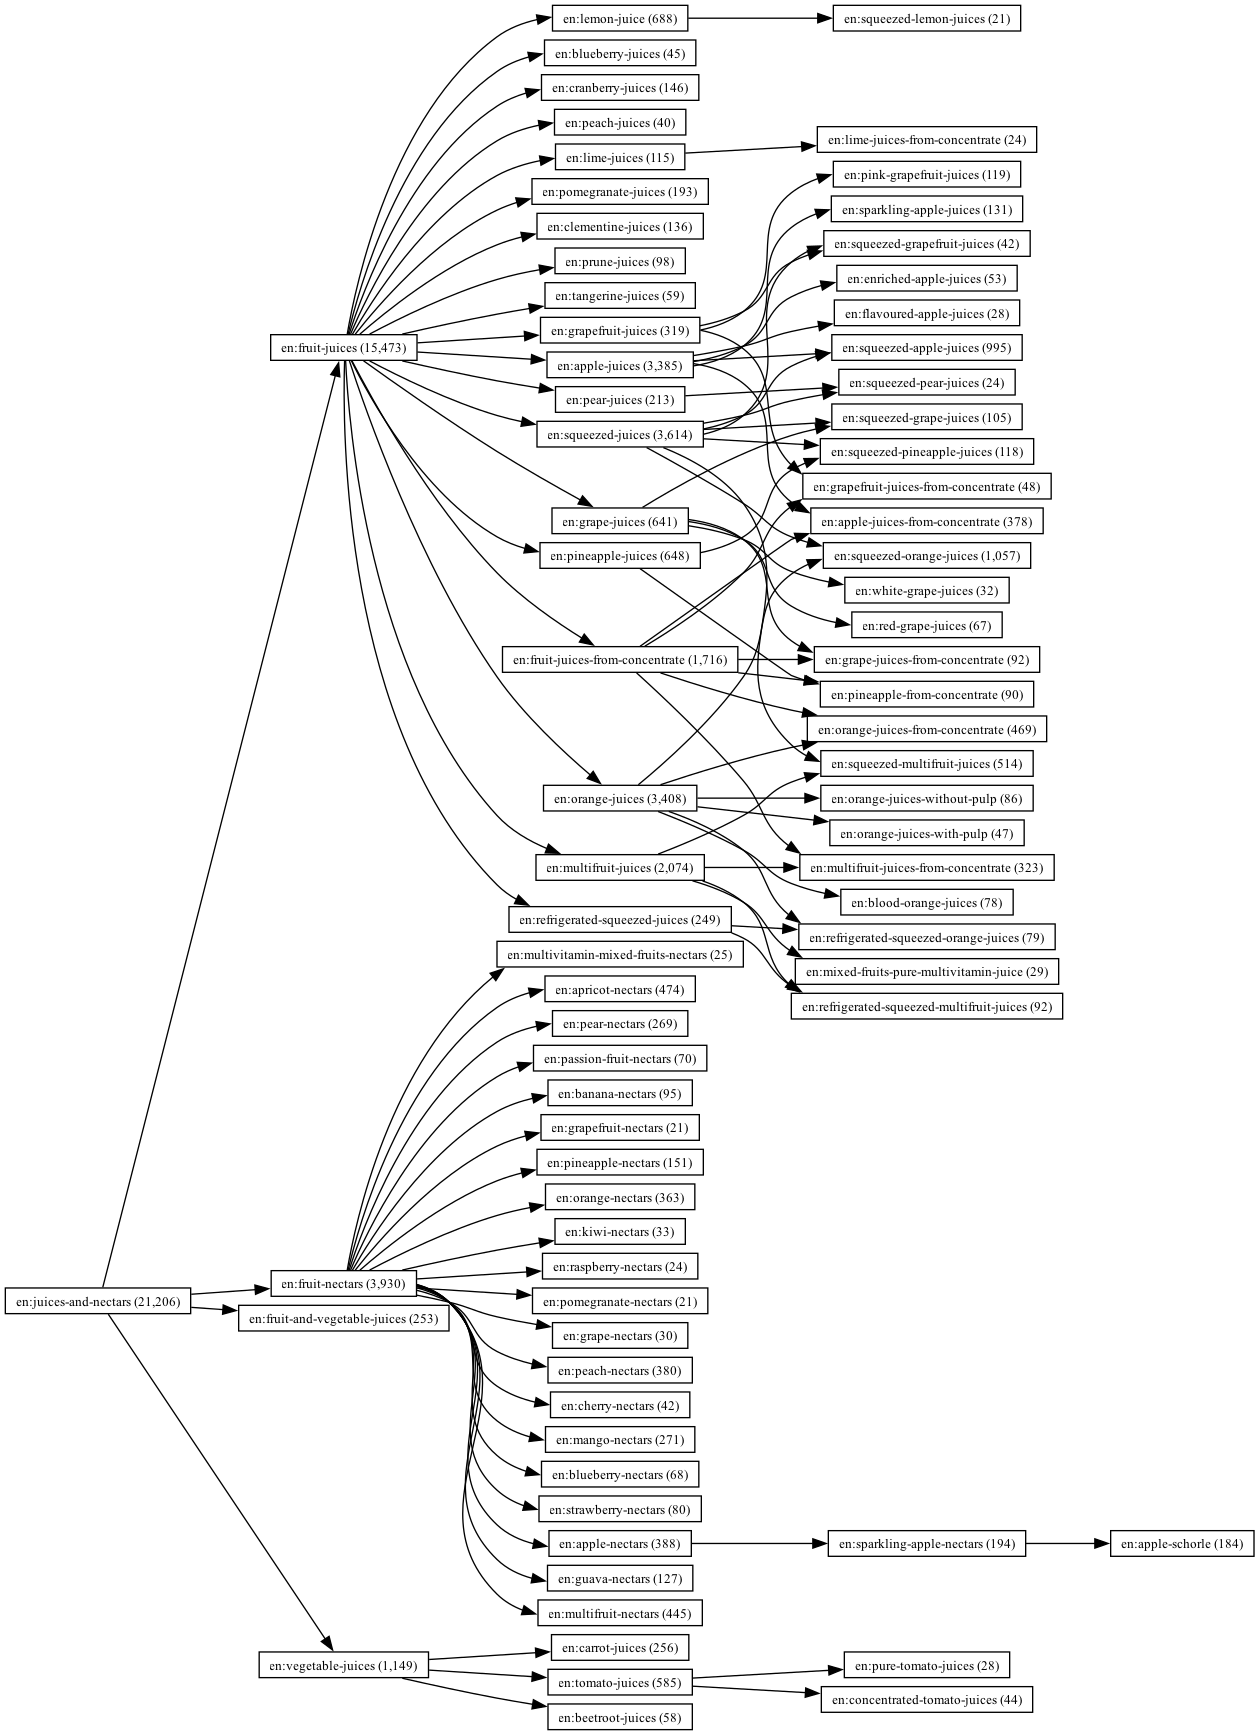

In [29]:
plot_graph(categories['en:juices-and-nectars'])

In [30]:
cat_df[cat_df.index.str.contains("chicory")].head(10)

known  \
id                                                   
en:instant-chicory                               1   
en:chicory                                       0   
en:instant-mix-of-chicory-and-coffee-powder      1   

                                                                                 name  \
id                                                                                      
en:instant-chicory                                                    Instant chicory   
en:chicory                                                                    chicory   
en:instant-mix-of-chicory-and-coffee-powder  Instant mix of chicory and coffee powder   

                                             products  \
id                                                      
en:instant-chicory                                197   
en:chicory                                        136   
en:instant-mix-of-chicory-and-coffee-powder        44   

                                                                              name_en  \
id                                                                                      
en:instant-chicory                                                    Instant chicory   
en:chicory                                                                       None   
en:instant-mix-of-chicory-and-coffee-powder  Instant mix of chicory and coffee powder   

                                            name_de  \
id                                                    
en:instant-chicory                             None   
en:chicory                                     None   
en:instant-mix-of-chicory-and-coffee-powder    None   

                                                                                       parents  \
id                                                                                               
en:instant-chicory                           en:instant-coffee-substitutes|en:plant-based-b...   
en:chicory                                                                                None   
en:instant-mix-of-chicory-and-coffee-powder      en:instant-beverages|en:plant-based-beverages   

                                             num_parents  num_children  
id                                                                      
en:instant-chicory                                     2             1  
en:chicory                                            -1            -1  
en:instant-mix-of-chicory-and-coffee-powder            2             0

In [31]:
show_children('en:fruit-based-beverages')

known                            name  \
id                                                                         
en:fruit-juices                        1                    Fruit juices   
en:fruit-nectars                       1                   Fruit nectars   
en:fruit-sodas                         1                     Fruit sodas   
en:aloe-vera-drinks                    1                Aloe Vera drinks   
en:fruit-and-milk-beverages            1        Fruit and milk beverages   
en:beverages-with-orange               1           Beverages with orange   
en:still-fruit-soft-drinks             1         Still fruit soft drinks   
en:fruit-and-plant-milk-beverages      1  Fruit and plant-milk beverages   
en:beverages-with-cranberry            1        Beverages with cranberry   

                                   products                         name_en  \
id                                                                            
en:fruit-juices                       15473                    Fruit juices   
en:fruit-nectars                       3930                   Fruit nectars   
en:fruit-sodas                         1575                     Fruit sodas   
en:aloe-vera-drinks                     397                Aloe Vera drinks   
en:fruit-and-milk-beverages             319        Fruit and milk beverages   
en:beverages-with-orange                253           Beverages with orange   
en:still-fruit-soft-drinks              166         Still fruit soft drinks   
en:fruit-and-plant-milk-beverages       100  Fruit and plant-milk beverages   
en:beverages-with-cranberry              98        Beverages with cranberry   

                                                  name_de  \
id                                                          
en:fruit-juices                                Fruchsäfte   
en:fruit-nectars                            Fruchtnektare   
en:fruit-sodas                            Fruchtlimonaden   
en:aloe-vera-drinks                      Aloe Vera Saften   
en:fruit-and-milk-beverages        Frucht- und Milchsäfte   
en:beverages-with-orange              Getränke mit Orange   
en:still-fruit-soft-drinks                           None   
en:fruit-and-plant-milk-beverages                    None   
en:beverages-with-cranberry            Cranberry Getränke   

                                                                             parents  \
id                                                                                     
en:fruit-juices                       en:fruit-based-beverages|en:juices-and-nectars   
en:fruit-nectars                      en:fruit-based-beverages|en:juices-and-nectars   
en:fruit-sodas                                     en:fruit-based-beverages|en:sodas   
en:aloe-vera-drinks                                         en:fruit-based-beverages   
en:fruit-and-milk-beverages                 en:dairy-drinks|en:fruit-based-beverages   
en:beverages-with-orange                                    en:fruit-based-beverages   
en:still-fruit-soft-drinks                                  en:fruit-based-beverages   
en:fruit-and-plant-milk-beverages  en:fruit-based-beverages|en:plant-based-milk-a...   
en:beverages-with-cranberry                                 en:fruit-based-beverages   

                                   num_parents  num_children  
id                                                            
en:fruit-juices                              2            22  
en:fruit-nectars                             2            24  
en:fruit-sodas                               2             7  
en:aloe-vera-drinks                          1             0  
en:fruit-and-milk-beverages                  2             0  
en:beverages-with-orange                     1             0  
en:still-fruit-soft-drinks                   1             5  
en:fruit-and-plant-milk-beverages            2             2  
en:beverages-with-cranberry                  1           

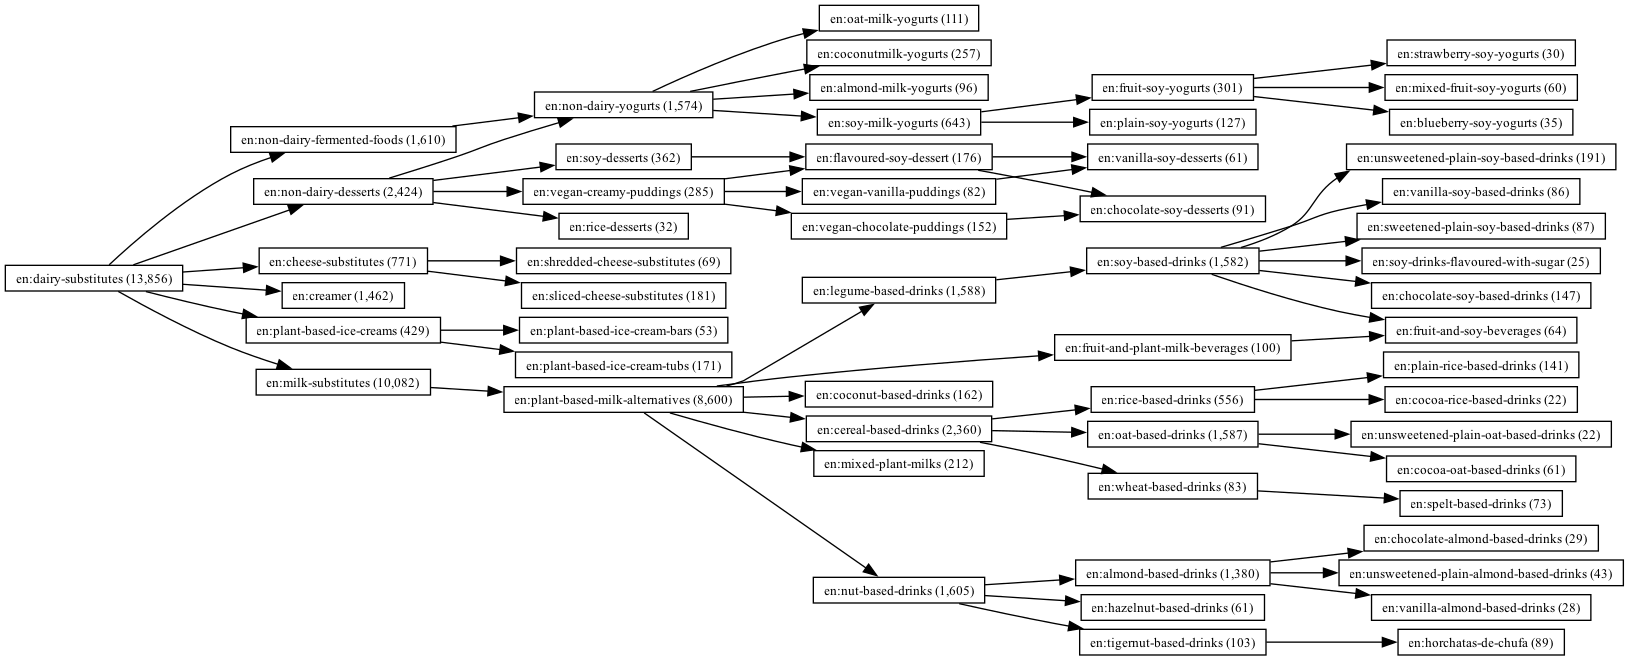

In [32]:
plot_graph(categories['en:dairy-substitutes'])

In [33]:
show_children('en:plant-based-foods')

known  \
id                                             
en:cereals-and-potatoes                    1   
en:fruits-and-vegetables-based-foods       1   
en:plant-based-spreads                     1   
en:pastas                                  1   
en:legumes-and-their-products              1   
en:seeds                                   1   
en:vegetable-fats                          1   
en:canned-plant-based-foods                1   
en:nuts-and-their-products                 1   
en:olive-tree-products                     1   
en:dried-plant-based-foods                 1   
en:coffees                                 1   
en:spices                                  1   
en:pickles                                 1   
en:frozen-plant-based-foods                1   
en:plant-based-pickles                     1   
en:flours                                  1   
en:culinary-plants                         1   
en:prepared-vegetables                     1   
en:flakes                                  1   
en:fresh-plant-based-foods                 1   
en:sunflower-seeds-and-their-products      1   
en:plant-based-creams                      1   
en:plant-based-meals                       1   
en:pumpkin-and-squash-plant-products       1   
en:seaweeds-and-their-products             1   
en:vegetable-broths                        1   
en:cheese-substitutes                      1   
en:puffed-grains                           1   
en:sprouts                                 1   
en:starches                                1   
en:bran                                    1   
en:nutmeg-tree-products                    1   
en:stevia-and-their-products               1   
en:coriander-products                      1   
en:freeze-dried-plant-based-foods          1   
en:refrigerated-plant-based-foods          1   
en:powdered-plant-milks                    1   
en:potted-plants                           1   
en:fried-plant-based-foods                 1   
en:fenugreek-products                      1   
en:psyllium                                1   
en:fennel                                  1   
en:pan-fried-vegetables                    1   
en:fruits-nuts-seed-variety-packs          1   
en:egg-substitutes                         1   

                                                                     name  \
id                                                                          
en:cereals-and-potatoes                              Cereals and potatoes   
en:fruits-and-vegetables-based-foods    Fruits and vegetables based foods   
en:plant-based-spreads                                Plant-based spreads   
en:pastas                                                          Pastas   
en:legumes-and-their-products                  Legumes and their products   
en:seeds                                                            Seeds   
en:vegetable-fats                                          Vegetable fats   
en:canned-plant-based-foods                      Canned plant-based foods   
en:nuts-and-their-products                        Nuts and their products   
en:olive-tree-products                                Olive tree products   
en:dried-plant-based-foods                        Dried plant-based foods   
en:coffees                                                        Coffees   
en:spices                                                          Spices   
en:pickles                                                        Pickles   
en:frozen-plant-based-foods                      Frozen plant-based foods   
en:plant-based-pickles                                Plant-based pickles   
en:flours                                                          Flours   
en:culinary-plants                                        Culinary plants   
en:prepared-vegetables                                Prepared vegetables   
en:flakes                                                          Flakes   
en:fresh-plant-based-foods              

In [34]:
#categories["it:trenette"].children
#cat_df.loc["it:trenette"]#.products
#cat_df[~cat_df.index.duplicated()]

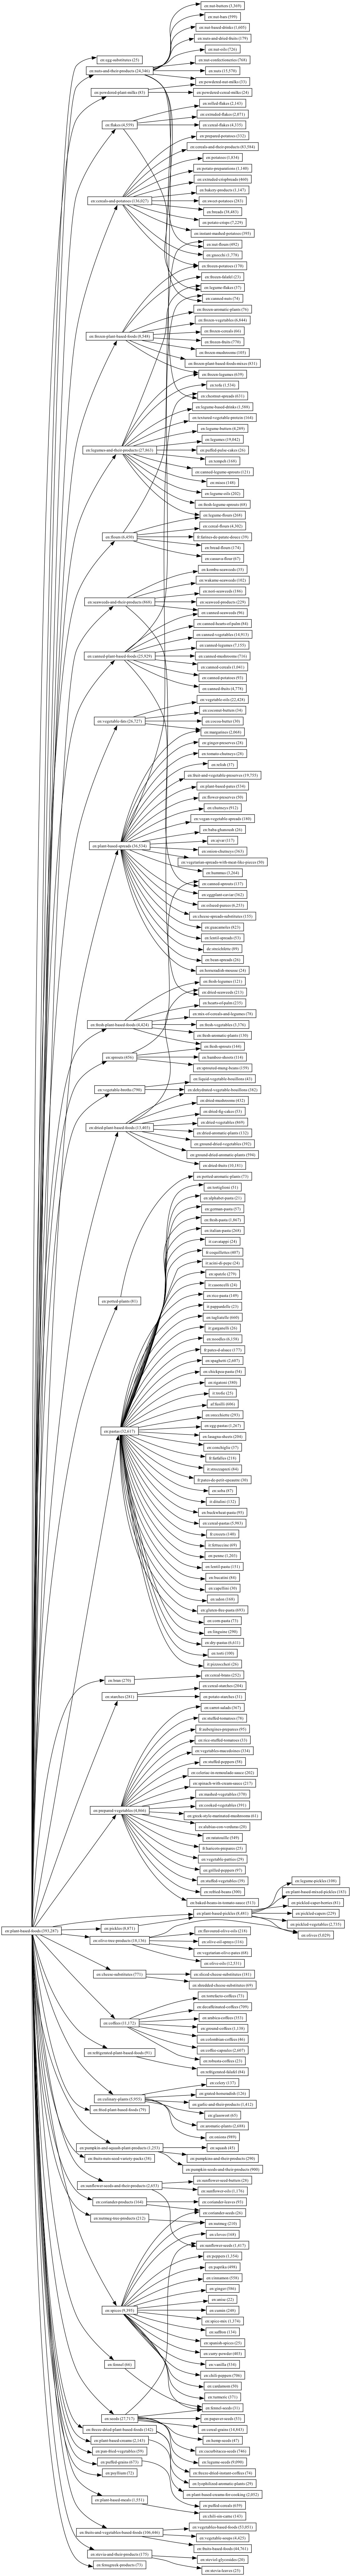

In [35]:
plot_graph(categories['en:plant-based-foods'], max_depth=2)

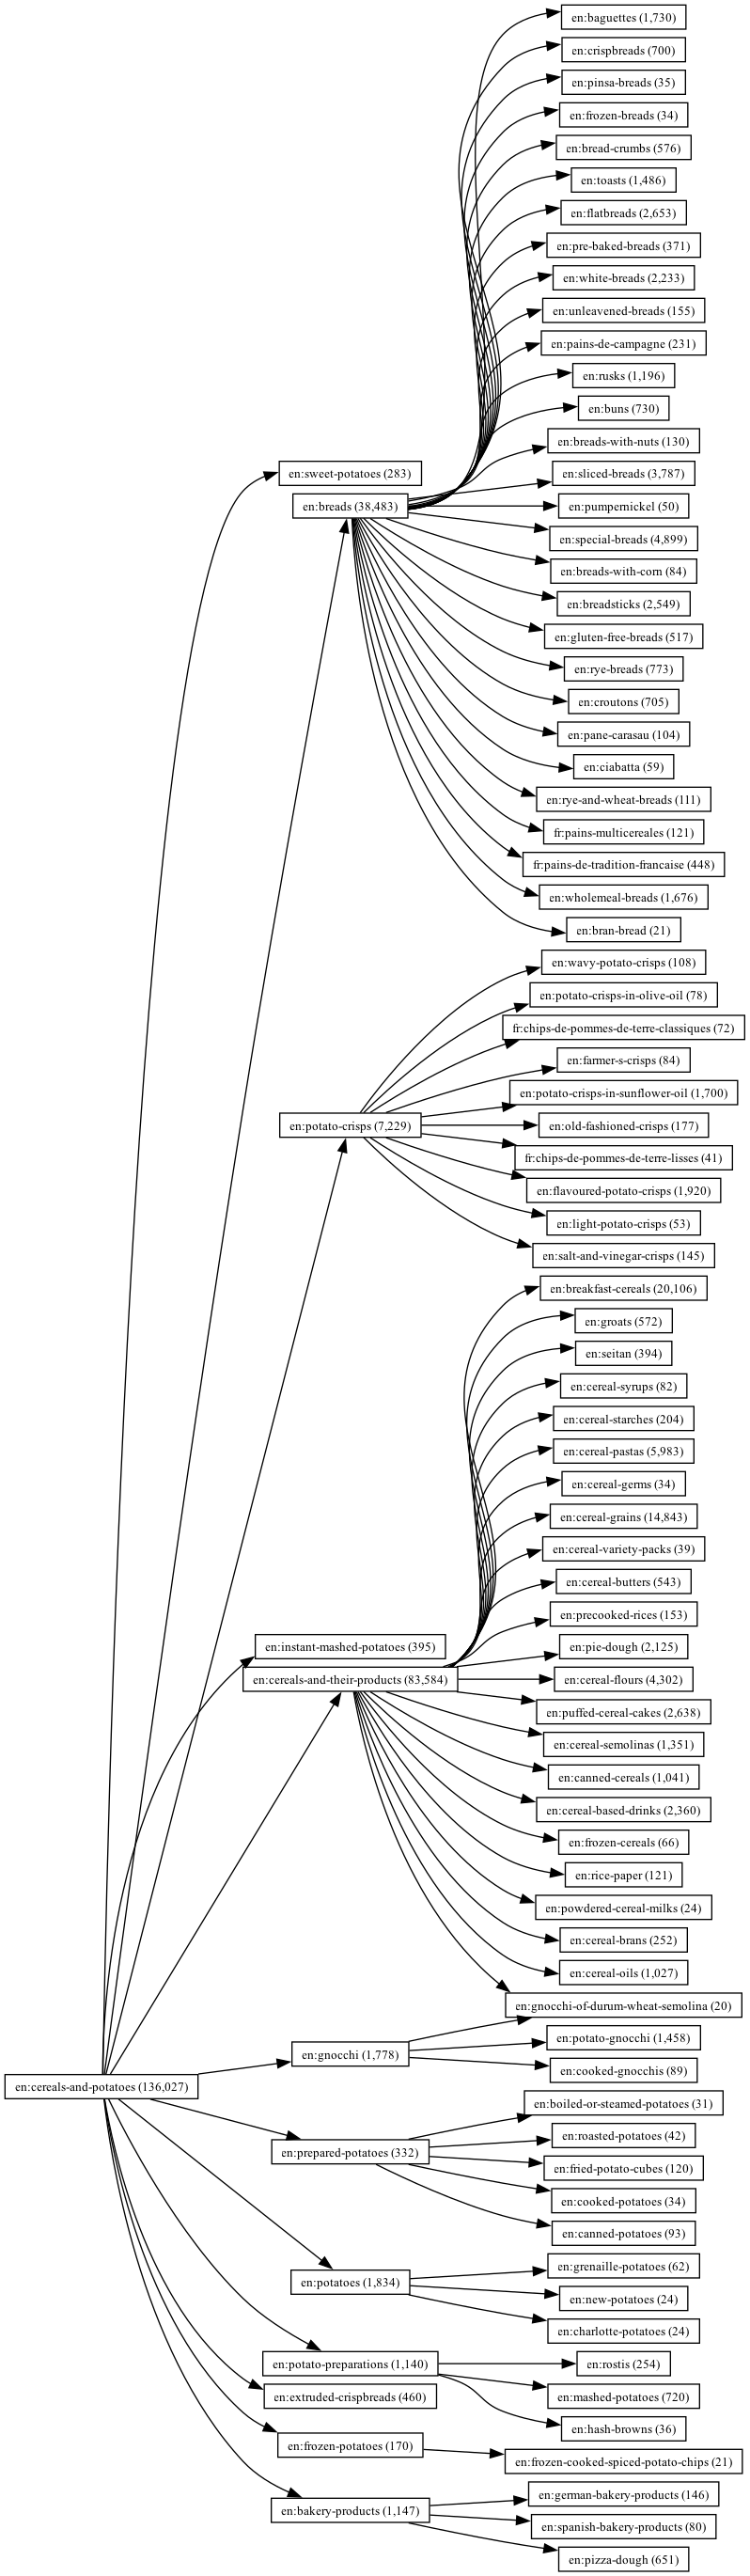

In [36]:
plot_graph(categories["en:cereals-and-potatoes"], max_depth=2)

### Any taxonomy entry contains name of parent

In [82]:
parents = cat_df.index.map(lambda x: '|'.join([cat.id[3:] for cat in categories[x].parents]) if categories[x] else None)
words = cat_df.index.map(lambda x: x[3:].split('-'))
df = pd.concat([pd.Series(words), pd.Series(parents)], axis=1)
#df.index = cat_df.index
df.columns = ['words', 'parents']

df['in_parent'] = df.apply(lambda row: [word for word in row.words if word in row.parents],axis = 1)
#df[df.in_parent.map(len) != 0]
df.in_parent.value_counts().head(50)

in_parent
[]               1085
[sauces]           60
[cheeses]          45
[yogurts]          40
[jams]             36
[beers]            32
[syrups]           32
[rices]            26
[honeys]           23
[wines]            21
[chocolates]       21
[pork]             20
[oils]             20
[cheese]           20
[milks]            20
[juices]           19
[nectars]          19
[sausages]         18
[spreads]          18
[sorbets]          18
[pasta]            18
[dried]            17
[breads]           16
[sandwiches]       16
[chicken]          16
[canned]           15
[pies]             15
[beef]             15
[crisps]           15
[soups]            15
[beverages]        14
[rillettes]        14
[terrines]         13
[frozen]           13
[chocolate]        13
[meat]             13
[teas]             13
[biscuits]         13
[vegetables]       13
[cakes]            13
[butters]          12
[meals]            11
[pizzas]           11
[salads]           10
[biscuit]          10


## Post-Processing

In [37]:
# only categories with taxnomomy entry
cat_df = cat_df[cat_df.name_en.notnull()]
cat_df

known                             name  \
id                                                                           
en:plant-based-foods-and-beverages      1  Plant-based foods and beverages   
en:plant-based-foods                    1                Plant-based foods   
en:snacks                               1                           Snacks   
en:sweet-snacks                         1                     Sweet snacks   
en:beverages                            1                        Beverages   
...                                   ...                              ...   
en:steviol-glycosides                   1               Steviol glycosides   
en:quail                                1                            Quail   
en:saveloy-from-obernai-alsace          1      Saveloy from Obernai Alsace   
en:watercress                           1                       Watercress   
en:poultry-liver                        1                    Poultry liver   

                                    products                          name_en  \
id                                                                              
en:plant-based-foods-and-beverages    452890  Plant-based foods and beverages   
en:plant-based-foods                  393287                Plant-based foods   
en:snacks                             275343                           Snacks   
en:sweet-snacks                       202380                     Sweet snacks   
en:beverages                          174087                        Beverages   
...                                      ...                              ...   
en:steviol-glycosides                     20               Steviol glycosides   
en:quail                                  20                            Quail   
en:saveloy-from-obernai-alsace            20      Saveloy from Obernai Alsace   
en:watercress                             20                       Watercress   
en:poultry-liver                          20                    Poultry liver   

                                                                  name_de  \
id                                                                          
en:plant-based-foods-and-beverages  Pflanzliche Lebensmittel und Getränke   
en:plant-based-foods                             Pflanzliche Lebensmittel   
en:snacks                                                          Imbiss   
en:sweet-snacks                                               Süßer Snack   
en:beverages                                                     Getränke   
...                                                                   ...   
en:steviol-glycosides                                                None   
en:quail                                                             None   
en:saveloy-from-obernai-alsace                                       None   
en:watercress                                               Brunnenkresse   
en:poultry-liver                                            Geflügelleber   

                                                                              parents  \
id                                                                                      
en:plant-based-foods-and-beverages                                                      
en:plant-based-foods                               en:plant-based-foods-and-beverages   
en:snacks                                                                               
en:sweet-snacks                                                             en:snacks   
en:beverages                                  en:beverages-and-beverages-preparations   
...                                                                               ...   
en:steviol-glycosides               en:natural-sugar-substitutes|en:stevia-and-the...   
en:quail                                                                 en:poultries   
en:saveloy-from-obernai-alsace                                            e

## Save Categories

In [43]:
cat_df.name_en.rename('name').reset_index().to_json("./tax_en.json", orient='records')

In [39]:
cat_df.to_csv("./off_category_freq.csv")